The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, I built a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

The accuracy of the model is 0.77

In [1]:
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from xgboost import cv
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Start - Add new feature Ticket_type
train['Ticket_type']=train['Ticket'].apply(lambda x:x[0:3])
train['Ticket_type']=train['Ticket_type'].astype('category')
train['Ticket_type']=train['Ticket_type'].cat.codes

test['Ticket_type']=test['Ticket'].apply(lambda x:x[0:3])
test['Ticket_type']=test['Ticket_type'].astype('category')
test['Ticket_type']=test['Ticket_type'].cat.codes
# End

In [4]:
# Start - Add new feature Had_cabin
print(train['Cabin'].unique())
# ★ pandas 中的 nan 算作 float 类型
train['Had_Cabin']=train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Had_Cabin']=test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
# End

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


In [5]:
# Start - Add new feature Family_size
train['Family_size']=train['SibSp']+train['Parch']+1
test['Family_size']=test['SibSp']+test['Parch']+1
# End

In [6]:
# Start - Deal null values
temp=pd.DataFrame(train.isnull().sum()).reset_index()
temp[temp[0]>0]['index']

# End

5          Age
10       Cabin
11    Embarked
Name: index, dtype: object

In [7]:
# Start - Group Embarked values
train.groupby('Embarked').size()
test.groupby('Embarked').size()
# End

Embarked
C    102
Q     46
S    270
dtype: int64

In [8]:
# Start - Handle missing values
train['Embarked'].fillna('S',inplace=True)
test['Embarked'].fillna('S',inplace=True)
train['Embarked']=train['Embarked'].astype('category')
test['Embarked']=test['Embarked'].astype('category')
# 年龄空值 按正态分布随机赋值
mean_age=train['Age'].mean()
std_age=train['Age'].std()
na_count_age=train['Age'].isnull().sum()
na_rand_list=np.random.randint(mean_age-std_age,mean_age+std_age,size=na_count_age)
train.loc[train['Age'].isna(),'Age']=na_rand_list

mean_age=test['Age'].mean()
std_age=test['Age'].std()
na_count_age_t=test['Age'].isnull().sum()
na_rand_list_test=np.random.randint(mean_age-std_age,mean_age+std_age,size=na_count_age_t)
test.loc[test['Age'].isna(),'Age']=na_rand_list_test

train['Age']=train['Age'].astype(int)
test['Age']=test['Age'].astype(int)
# End

In [9]:
# Start - Map categorical values to integers
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
train['Sex']=train['Sex'].map({'male':0,'female':1}).astype(int)

test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
test['Sex']=test['Sex'].map({'male':0,'female':1}).astype(int)
# End0

In [10]:
# Start - Drop unnecessary columns
drop_cols=['PassengerId','Name','SibSp','Parch','Ticket','Cabin']
train=train.drop(drop_cols,axis=1)
PassengerId=test['PassengerId']
test=test.drop(drop_cols,axis=1)
# End

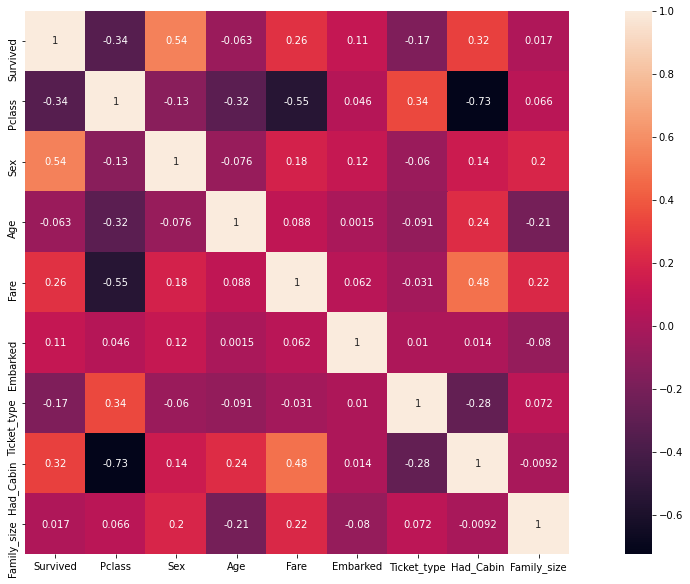

In [11]:
# Start - Check correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),square=True,annot=True)
# End

In [12]:
# Start - Model Building
y_train=train['Survived']
x_train=train.drop(['Survived'],axis=1)
x_test=test

params={
    'n_estimators':200,
    'objective':'binary:logistic',
    'max_depth':4,
    'learning_rate':0.1
}
# python 语法，字典对象前加两个*可以转化成以key为参数名且对应value为参数值带入到方法参数列表中。

model=xgb.XGBClassifier(**params).fit(x_train,y_train)
y_test=model.predict(x_test)
submission=pd.DataFrame({'PassengerId':PassengerId,'Survived':y_test})
submission.to_csv("submission.csv",index=False)
#End

[15:31:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
train.describe()


,Survived,Pclass,Sex,Age,Fare,Embarked,Ticket_type,Had_Cabin,Family_size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.402918,32.204208,0.361392,77.945006,0.228956,1.904602
std,0.486592,0.836071,0.477990,13.544199,49.693429,0.635673,45.009915,0.420397,1.613459
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.000000,7.910400,0.000000,44.000000,0.000000,1.000000
50%,0.000000,3.000000,0.000000,28.000000,14.454200,0.000000,81.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,37.000000,31.000000,1.000000,123.000000,0.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,153.000000,1.000000,11.000000
